## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-12 16:12:37.822455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 16:12:37.822503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()
    
def plot_hist(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['loss'], label = "Loss")
    plt.plot(hist.history['val_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits_datagen")
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-05-12 16:13:01.367121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-12 16:13:01.367222: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-12 16:13:01.367337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tall10): /proc/driver/nvidia/version does not exist
2022-05-12 16:13:01.369752: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 13s 37ms/step - loss: 0.4362 - sparse_categorical_accuracy: 0.9084



## Creating a data augmentation process

In [5]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building callbacks

In [6]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Knowledge distillation

In [7]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 87s 53ms/step - sparse_categorical_accuracy: 0.3457 - student_loss: 1.7681 - loss: 1.6677 - val_sparse_categorical_accuracy: 0.3624 - val_student_loss: 3.6844 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 85s 53ms/step - sparse_categorical_accuracy: 0.4717 - student_loss: 1.4605 - loss: 1.3802 - val_sparse_categorical_accuracy: 0.4623 - val_student_loss: 2.4682 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 85s 53ms/step - sparse_categorical_accuracy: 0.5291 - student_loss: 1.3195 - loss: 1.2476 - val_sparse_categorical_accuracy: 0.5139 - val_student_loss: 2.4377 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 89s 55ms/step - sparse_categorical_accuracy: 0.5630 - student_loss: 1.2341 - loss: 1.1674 - val_sparse_categorical_accuracy: 0.4890 - val_student_loss: 2.5252 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 85s 53ms/step - sparse_cate

Epoch 35/100
1562/1562 [==============================] - 88s 54ms/step - sparse_categorical_accuracy: 0.7738 - student_loss: 0.6583 - loss: 0.6219 - val_sparse_categorical_accuracy: 0.7706 - val_student_loss: 2.4286 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 89s 55ms/step - sparse_categorical_accuracy: 0.7730 - student_loss: 0.6561 - loss: 0.6203 - val_sparse_categorical_accuracy: 0.7686 - val_student_loss: 2.4253 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 90s 55ms/step - sparse_categorical_accuracy: 0.7691 - student_loss: 0.6616 - loss: 0.6250 - val_sparse_categorical_accuracy: 0.7639 - val_student_loss: 2.4235 - lr: 1.0000e-03
Epoch 38/100
1562/1562 [==============================] - 89s 55ms/step - sparse_categorical_accuracy: 0.7709 - student_loss: 0.6630 - loss: 0.6266 - val_sparse_categorical_accuracy: 0.7647 - val_student_loss: 2.4345 - lr: 1.0000e-03
Epoch 39/100
1562/1562 [==============================] - 88s 54

1562/1562 [==============================] - 90s 55ms/step - sparse_categorical_accuracy: 0.7699 - student_loss: 0.6589 - loss: 0.6228 - val_sparse_categorical_accuracy: 0.7655 - val_student_loss: 2.4254 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 87s 54ms/step - sparse_categorical_accuracy: 0.7723 - student_loss: 0.6551 - loss: 0.6192 - val_sparse_categorical_accuracy: 0.7659 - val_student_loss: 2.4301 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 88s 54ms/step - sparse_categorical_accuracy: 0.7730 - student_loss: 0.6578 - loss: 0.6217 - val_sparse_categorical_accuracy: 0.7671 - val_student_loss: 2.4262 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 92s 57ms/step - sparse_categorical_accuracy: 0.7717 - student_loss: 0.6580 - loss: 0.6217 - val_sparse_categorical_accuracy: 0.7680 - val_student_loss: 2.4265 - lr: 1.0000e-06
Epoch 71/100
1562/1562 [==============================] - 89s 54ms/step - spa

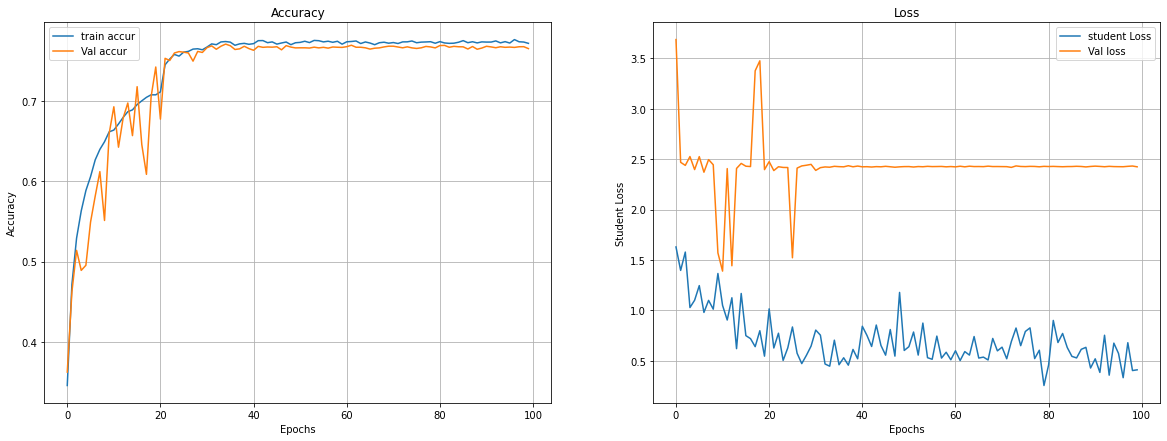

Saving model 


2022-05-12 18:43:09.734188: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.9/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [8]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_alpha_{a}_temp_{5}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

    dist = Distiller(teacher, student)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(datagen.flow(x_train, y_train, 
          batch_size = BATCH_SIZE),
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_KD_notebook_alpha{a}.png")


    print("Saving model ")
    student.save(f"Resnet8_KD_notebook_alpha{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student.save_weights(f"w_resnet8_alpha_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")